In [21]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch

# This has neural network layer primitives that you can use to build things quickly
import torch.nn as nn

# This has things like activation functions and other useful nonlinearities
from torch.nn import functional as F

# This has various gradient descent algorithms
import torch.optim

# In order to take derivatives, we have to wrap things as a Variable or a Parameter.
# Variables are things like inputs to the model
# Parameters are things like weights
# If you make a child class of nn.Module, it automatically keeps tracks of all parameters declared during 
# __init__ for you - really handy!
from torch.autograd import Variable
from torch.nn import Parameter

Populating the interactive namespace from numpy and matplotlib


## Linear regression example

In modern neural network libraries, one of the big things is that the library handles calculating derivatives of expressions analytically for you without having to do things by hand. These derivatives can be used for a lot of things, not just training a standard neural network.

In this example, we'll set up a linear regression on a simple dataset and use PyTorch's automatic differentiation to optimize the parameters via gradient descent.

For this example, we'll just use fake data, since the main point is to get the idea of how PyTorch works.

### Some things to play with:

- Use nn.Linear to set up the regression rather than doing it directly 
- Try changing the model/data to some arbitrary nonlinear regression problem
- Use a different objective function for the regression
- Use the derivatives for something else
- Implement a proper train/test split

## Data

First we'll make some fake data. This will just be some noisy points on a line/plane/etc.

In [45]:
def makeData(features = 1, outputs = 1, N=50):
    A = np.random.randn(features, outputs)
    b = np.random.randn(outputs)
    
    x = np.random.randn(N, features)*5
    return x, np.matmul(x,A)+b + np.random.randn(N, outputs)

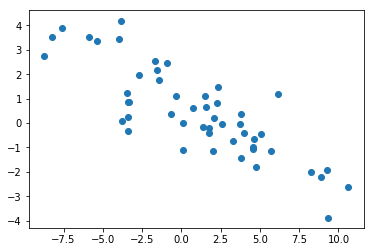

In [32]:
# Example generated dataset

xdata, ydata = makeData()

plt.scatter(xdata,ydata)
plt.show()

## Regression model

We'll now make a child class of nn.Module to take advantage of PyTorch automatically keeping track of parameters for us.

In [53]:
class LinearRegression(nn.Module):
    # This function is called when you make an instance of this class
    def __init__(self, features = 1, outputs = 1):
        # Inherit stuff from nn.Module
        super(LinearRegression,self).__init__()
        
        # Initialize parameters of the regression
        # In this case, the regression will look like: y = A*x + b
        # We will want to run this on all the data in parallel, so 
        # 'x' will be a matrix of size BATCH x FEATURES
        # 'A' should be a matrix of size FEATURES x OUTPUTS
        # 'b' should be a vector of size OUTPUTS
        #
        # We'll initialize these to Gaussian distributed random values
        # 
        # For stuff to work with PyTorch, it has to be converted to FloatTensor, LongTensor, etc 
        # rather than being NumPy arrays. We can then wrap it in Variable or Parameter as needed.
        
        self.A = Parameter(torch.FloatTensor(np.random.randn(features, outputs)))
        self.b = Parameter(torch.FloatTensor(np.random.randn(outputs)))
        
        # This initializes a gradient descent algorithm - here, Stochastic Gradient Descent,
        # with a step size of 1e-2. The first argument is a list of parameters to do
        # gradient descent over - conveniently, PyTorch is keeping track of that for us so
        # we can just call self.parameters() to get the ones we've defined so far
        #
        # A commonly used optimizer that is a bit more sophisticated is torch.optim.Adam(),
        # which you could just swap out here
        self.optimizer = torch.optim.SGD(self.parameters(), lr = 1e-2)
        
    # This function takes an input batch and returns the output of the regression
    def forward(self,x):
        # torch.matmul does a matrix multiplication
        # If you do *, it means an element-wise multiplication
        #
        # Note that even though b is a vector, we can add it and PyTorch automatically reshapes
        # it and broadcasts it appropriately to each example
        return torch.matmul(x, self.A) + self.b
    
    # Here we'll put the error function we want to minimize for the regression problem. 
    # In machine learning this is usually called the 'loss'.
    #
    # In this case, we want to minimize the mean squared error between the true values (y)
    # and the predictions (p)
    # 
    # Writing .sum(1) means summing over axis 1. Writing .mean(0) means taking the average over
    # axis 0 (the batch dimension)
    # We can also write .mean() or .sum() as a short-hand to do that over all axes at once
    def loss(self, y, p):
        return ((y-p)**2).sum(1).mean(0)
    
    # Here we'll put the code to:
    # - Make predictions given the inputs
    # - Calculate the derivative of the error
    # - Perform gradient descent on the parameters
    def optimize(self, x, y):
        # PyTorch stores derivatives on the variables of interest directly, so
        # before we do anything we should zero those out.
        
        self.zero_grad()
        
        # We now calculate the predictions
        p = self.forward(x)
        
        # Now we calculate the error
        loss = self.loss(y,p)
        
        # Now, we calculate the derivative of all of the Parameters with respect to the error
        # If you call backward() multiple times, it accumulates all the derivatives additively
        # until you clear them.
        #
        # '.backward()' has to be called on a scalar. To do higher order derivatives, you need to use
        # functions from torch.autograd, so we won't get into that here.
        #
        # If you want to look at the derivatives directly, you can access for example:
        # self.A.grad
        # self.b.grad
        
        loss.backward()
        
        # Now, we will take one step of gradient descent
        
        self.optimizer.step()
        
        # Return the error so we can watch the model converge
        # We're projecting back to standard NumPy formats here so we
        # don't carry around excess PyTorch-specific information
        return loss.data.numpy()

## Fitting

Now lets fit the model. I've included a bit of code to show the results in real time as it trains.

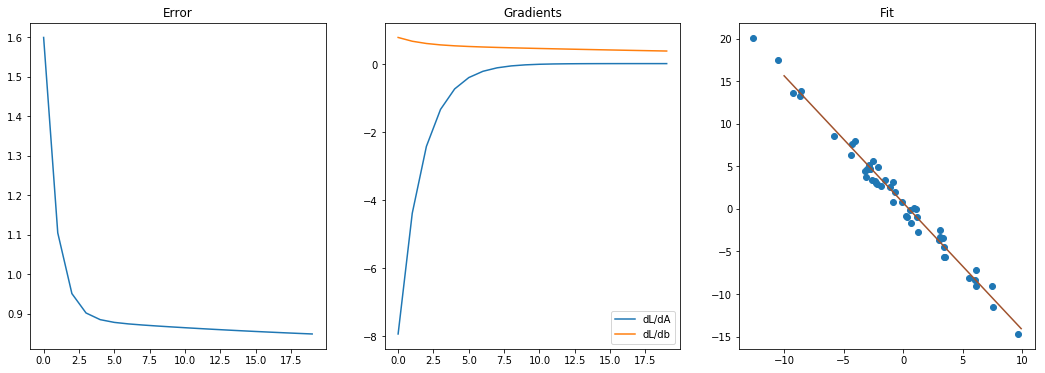

In [79]:
from IPython import display
import time

xdata, ydata = makeData()
linear = LinearRegression(xdata.shape[1], ydata.shape[1])
errors = []
grada = []
gradb = []

for epoch in range(20):
    # This trains the model. We have to wrap the inputs as Variables.
    # For more extensive work, its useful to define a function to do this mapping
    # since you end up doing it quite a lot.
    # Adding requires_grad=False for Variables you won't need derivatives for speeds things up a bit
    err = linear.optimize(Variable(torch.FloatTensor(xdata), requires_grad=False),
                          Variable(torch.FloatTensor(ydata), requires_grad=False))
    errors.append(err)
    
    # Storing gradients for visualization
    # The whole .data.numpy().copy() thing is to ensure that these are not pointers to the
    # PyTorch gradients but are just the actual numbers
    grada.append(linear.A.grad.data.numpy().copy()[0,0])
    gradb.append(linear.b.grad.data.numpy().copy()[0])
    
    # This is all plotting stuff
    plt.clf()
    plt.subplot(1,3,1)
    plt.title("Error")
    plt.plot(errors)
    
    plt.subplot(1,3,2)
    plt.title("Gradients")
    plt.plot(grada,label="dL/dA")
    plt.plot(gradb,label="dL/db")
    plt.legend()
    
    plt.subplot(1,3,3)
    x = np.arange(-10,10,0.1)
    x = x.reshape((x.shape[0],1))
    y = linear.forward(Variable(torch.FloatTensor(x), requires_grad=False)).data.numpy()    
    plt.title("Fit")
    plt.scatter(xdata,ydata)
    plt.plot(x,y,'sienna')
    
    plt.gcf().set_size_inches((18,6))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

plt.clf()

## 2d example

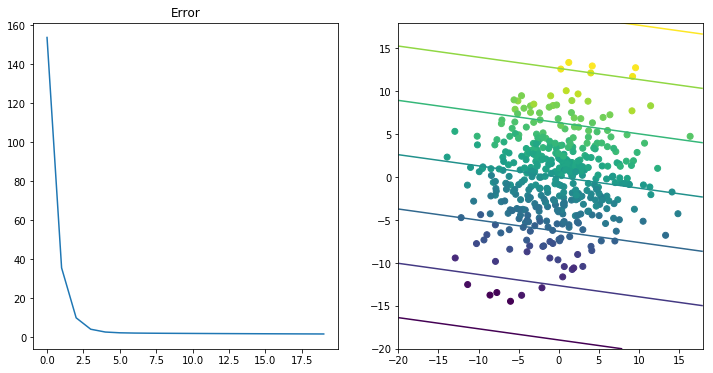

In [71]:
xdata, ydata = makeData(features=2, outputs=1, N=400)

linear = LinearRegression(xdata.shape[1], ydata.shape[1])
errors = []

for epoch in range(20):
    # This trains the model. We have to wrap the inputs as Variables.
    # For more extensive work, its useful to define a function to do this mapping
    # since you end up doing it quite a lot.
    # Adding requires_grad=False for Variables you won't need derivatives for speeds things up a bit
    err = linear.optimize(Variable(torch.FloatTensor(xdata), requires_grad=False),
                          Variable(torch.FloatTensor(ydata), requires_grad=False))
    errors.append(err)
    
    # This is all plotting stuff
    plt.clf()
    plt.subplot(1,2,1)
    plt.title("Error")
    plt.plot(errors)
    
    x1,x2 = np.meshgrid( np.arange(-20,20,2.0), np.arange(-20,20,2.0) )
    x1 = x1.reshape((400,1))
    x2 = x2.reshape((400,1))
    x = np.hstack([x1,x2])
    y = linear.forward(Variable(torch.FloatTensor(x), requires_grad=False)).data.numpy()
    
    plt.subplot(1,2,2)
    plt.contour(x[:,0].reshape((20,20)),
                x[:,1].reshape((20,20)),
                y[:,0].reshape((20,20)))
    plt.scatter(xdata[:,0],xdata[:,1], c=ydata[:,0])
    
    plt.gcf().set_size_inches((12,6))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

plt.clf()